In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Preprocessing & Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')

import joblib
import shap

# Loading the DataSet

In [3]:
# Load Data
df = pd.read_csv('credit_dataset.csv')

print("Original DataSet Shape Before Cleaning and Preprocessing:", df.shape)
df.info()

Original DataSet Shape Before Cleaning and Preprocessing: (855969, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855969 entries, 0 to 855968
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               855969 non-null  int64  
 1   member_id        855969 non-null  int64  
 2   loan_amnt        855969 non-null  int64  
 3   funded_amnt      855969 non-null  int64  
 4   funded_amnt_inv  855969 non-null  float64
 5   term             855969 non-null  int64  
 6   int_rate         855969 non-null  float64
 7   installment      855969 non-null  float64
 8   grade            855969 non-null  object 
 9   purpose          855969 non-null  object 
 10  dti              855969 non-null  float64
 11  default_ind      855969 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 78.4+ MB


# Data Cleaning

In [4]:
df_clean = df.drop(columns=['id', 'member_id']) # Droping this col because it don't predictive anything

# Checking for missing values
print("\nMissing Values per column:\n", df_clean.isnull().sum())
df_clean = df_clean.dropna()


Missing Values per column:
 loan_amnt          0
funded_amnt        0
funded_amnt_inv    0
term               0
int_rate           0
installment        0
grade              0
purpose            0
dti                0
default_ind        0
dtype: int64


# Data Processing

In [5]:
# Encoding grade col because it is having grades as A B C now i am converting them to numbers.
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df_clean['grade_mapped'] = df_clean['grade'].map(grade_mapping)

# Droping original grade column
df_clean = df_clean.drop(columns=['grade'])

# Encoding purpose col by using One-Hot Encoding
df_processed = pd.get_dummies(df_clean, columns=['purpose'], drop_first=True)

print("\nProcessed Data Info:", df_processed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855969 entries, 0 to 855968
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   855969 non-null  int64  
 1   funded_amnt                 855969 non-null  int64  
 2   funded_amnt_inv             855969 non-null  float64
 3   term                        855969 non-null  int64  
 4   int_rate                    855969 non-null  float64
 5   installment                 855969 non-null  float64
 6   dti                         855969 non-null  float64
 7   default_ind                 855969 non-null  int64  
 8   grade_mapped                855969 non-null  int64  
 9   purpose_credit_card         855969 non-null  bool   
 10  purpose_debt_consolidation  855969 non-null  bool   
 11  purpose_educational         855969 non-null  bool   
 12  purpose_home_improvement    855969 non-null  bool   
 13  purpose_house 

# EDA And Data Visualization

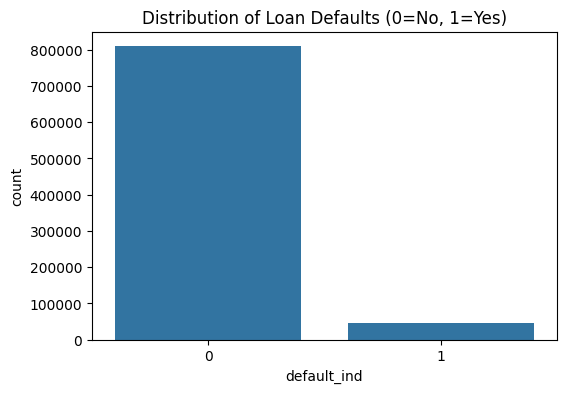

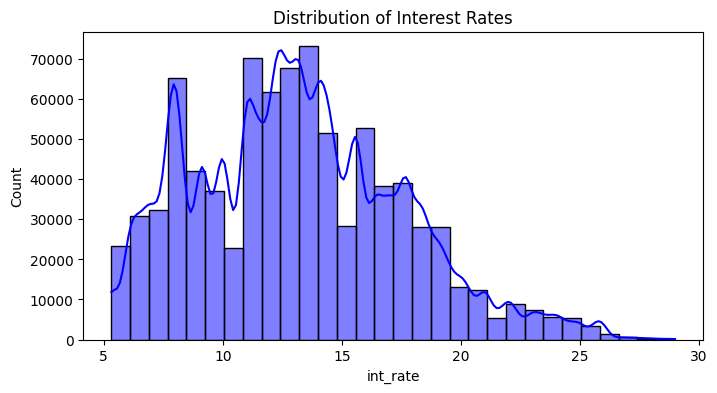

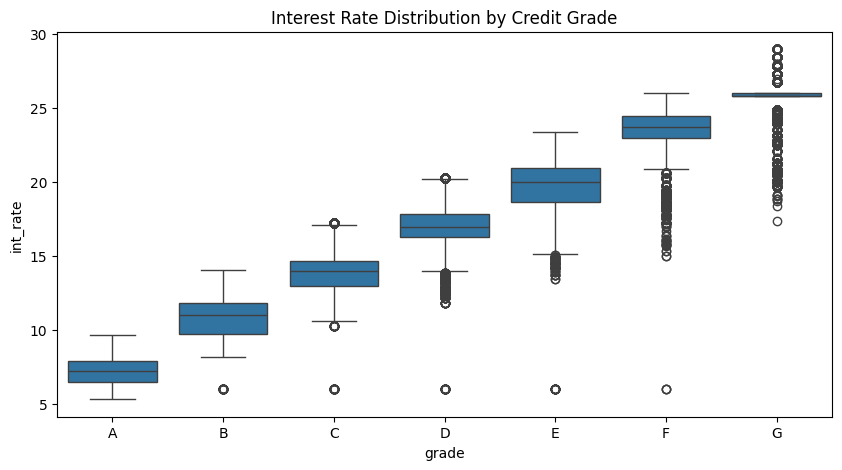

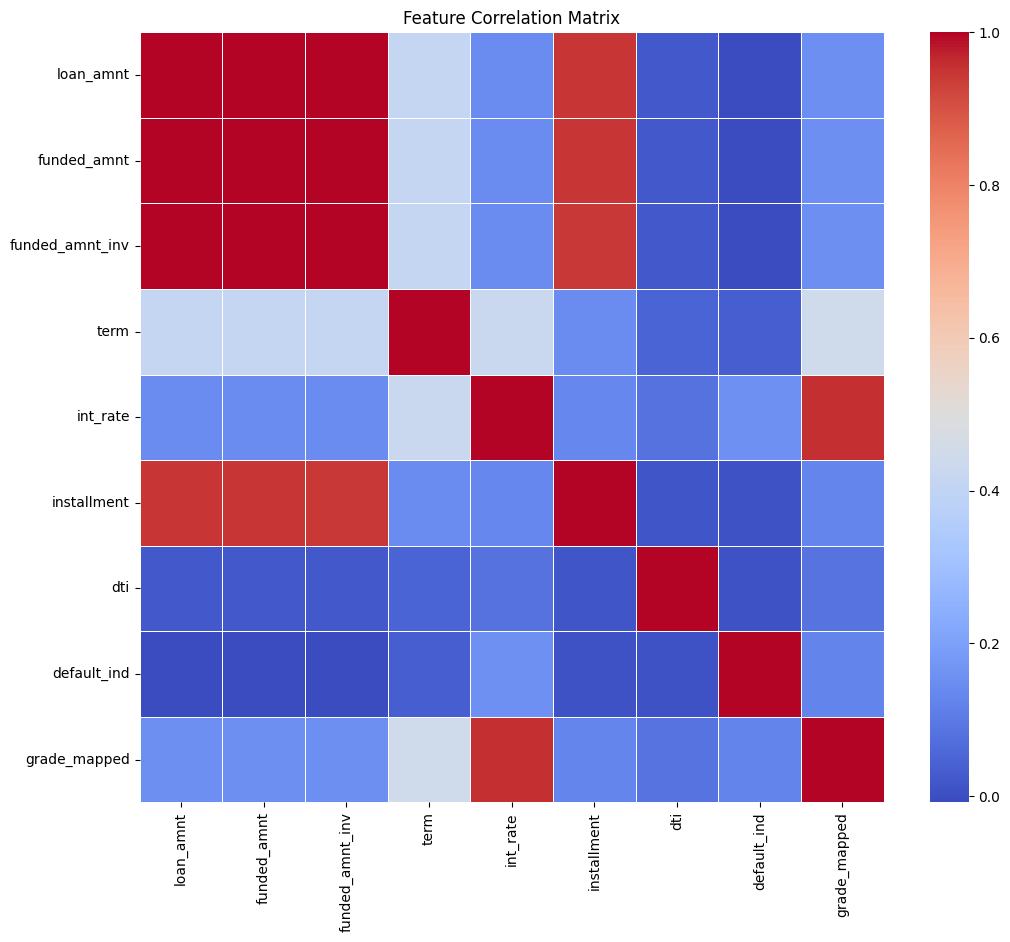

In [6]:
# Checking Distribution of the Target Variable for Classification
plt.figure(figsize=(6, 4))
sns.countplot(x='default_ind', data=df)
plt.title('Distribution of Loan Defaults (0=No, 1=Yes)')
plt.show()

# Checking Distribution of Interest Rates for Regression Target
plt.figure(figsize=(8, 4))
sns.histplot(df['int_rate'], bins=30, kde=True, color='blue')
plt.title('Distribution of Interest Rates')
plt.show()

# Using Boxplot for Distribtion of Interest Rate vs Grade
plt.figure(figsize=(10, 5))
sns.boxplot(x='grade', y='int_rate', data=df, order=['A','B','C','D','E','F','G'])
plt.title('Interest Rate Distribution by Credit Grade')
plt.show()

# Correlation Matrix
plt.figure(figsize=(12, 10))
numeric_cols = df_processed.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

# Statistical Analysis

In [7]:
print("\n   Statistical Inference :-    \n")

# Performing Hypothesis To know if there is a significant difference in Loan Amount between defaulted and non-defaulted loans
group_default = df[df['default_ind'] == 1]['loan_amnt']
group_nodefault = df[df['default_ind'] == 0]['loan_amnt']

t_stat, p_val = stats.ttest_ind(group_default, group_nodefault)

print(f"T-Test Results for Loan Amount (Default vs Non-Default):")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05:
    print("Result: Significant difference in loan amounts between defaults and non-defaults.")
else:
    print("Result: No significant difference found.")


   Statistical Inference :-    

T-Test Results for Loan Amount (Default vs Non-Default):
T-statistic: -4.5398
P-value: 5.6328e-06
Result: Significant difference in loan amounts between defaults and non-defaults.


# Feature Scaling & Split

In [15]:
X = df_processed.drop(columns=['default_ind', 'int_rate'])
y_class = df_processed['default_ind']
y_reg = df_processed['int_rate']

# For demonstration speed and lack of system requirements(no gpu) i am using a subset of data as given dataset has 800k rows, some models like SVM and KNN will be very slow.Taking sample of 20k rows for training demo.

# In a real top-tier production environment, we would use Spark or optimize, but here we sample for execution feasibility. (for this i asked google and gemini)

SAMPLE_SIZE = 20000
if len(X) > SAMPLE_SIZE:
    df_sample = df_processed.sample(n=SAMPLE_SIZE, random_state=42)
    X_sample = df_sample.drop(columns=['default_ind', 'int_rate'])
    y_class_sample = df_sample['default_ind']
    y_reg_sample = df_sample['int_rate']
else:
    X_sample = X
    y_class_sample = y_class
    y_reg_sample = y_reg

# Split
X_train, X_test, y_train_class, y_test_class = train_test_split(X_sample, y_class_sample, test_size=0.3, random_state=42)
_, _, y_train_reg, y_test_reg = train_test_split(X_sample, y_reg_sample, test_size=0.3, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Creation, Training, and Evaluation

# 1) Classification Models :-

In [16]:
# 1) Classification Models :-
print("\n" + "="*40)
print("   CLASSIFICATION MODEL RESULTS")
print("="*40)

class_models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500)
}


class_results = [] # Creating a empty list to store results

for name, model in class_models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train_class)
    y_pred = model.predict(X_test_scaled)
    
    try:
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test_class, y_prob)
    except:
        auc = 0.5

    
    acc = accuracy_score(y_test_class, y_pred)
    prec = precision_score(y_test_class, y_pred, zero_division=0)
    f1 = f1_score(y_test_class, y_pred, zero_division=0)
    
    class_results.append({
        "Model": name,
        "Accuracy": acc,
        "ROC AUC": auc,
        "Precision": prec,
        "F1 Score": f1
    })



   CLASSIFICATION MODEL RESULTS
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training SVM...
Training KNN...
Training Naive Bayes...
Training Neural Network (MLP)...


# Displaying Classification Results

In [18]:
class_df = pd.DataFrame(class_results).sort_values(by="ROC AUC", ascending=False)
print("\nClassification Leaderboard:")
print(class_df)


Classification Leaderboard:
                  Model  Accuracy   ROC AUC  Precision  F1 Score
0   Logistic Regression  0.942333  0.685879   0.000000  0.000000
2         Random Forest  0.942333  0.665542   0.000000  0.000000
7  Neural Network (MLP)  0.936833  0.663562   0.097561  0.020672
6           Naive Bayes  0.058667  0.646069   0.057577  0.108867
1         Decision Tree  0.936667  0.628549   0.160000  0.040404
3               XGBoost  0.940500  0.622854   0.133333  0.011080
5                   KNN  0.936833  0.548139   0.028571  0.005249
4                   SVM  0.942333  0.434711   0.000000  0.000000


# 2) Regression Models :-

In [19]:
# 2) Regression Models :-
print("\n" + "="*40)
print("   REGRESSION MODEL RESULTS (Target: Int_Rate)")
print("="*40)

reg_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree Reg": DecisionTreeRegressor(max_depth=10),
    "Random Forest Reg": RandomForestRegressor(n_estimators=100, max_depth=10),
    "XGBoost Reg": XGBRegressor(),
    "Neural Network Reg": MLPRegressor(hidden_layer_sizes=(64,32), max_iter=500)
}

reg_results = [] # Creating a empty list to store results

for name, model in reg_models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train_reg)
    y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test_reg, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_reg, y_pred)
    
    reg_results.append({
        "Model": name,
        "RMSE": rmse,
        "R2 Score": r2
    })



   REGRESSION MODEL RESULTS (Target: Int_Rate)
Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training Decision Tree Reg...
Training Random Forest Reg...
Training XGBoost Reg...
Training Neural Network Reg...


In [20]:
reg_df = pd.DataFrame(reg_results).sort_values(by="R2 Score", ascending=False)
print("\nRegression Leaderboard:")
print(reg_df)


Regression Leaderboard:
                Model      RMSE  R2 Score
6  Neural Network Reg  0.441042  0.989778
5         XGBoost Reg  0.766637  0.969114
4   Random Forest Reg  1.075871  0.939171
3   Decision Tree Reg  1.128475  0.933078
1    Ridge Regression  1.255823  0.917121
0   Linear Regression  1.255964  0.917102
2    Lasso Regression  1.628758  0.860588


# BEST MODEL SELECTION & Showing it in a Webpage

In [21]:
best_class_model = class_df.iloc[0]['Model']
print(f"\nBest Classification Model for Deployment: {best_class_model}")

best_reg_model = reg_df.iloc[0]['Model']
print(f"Best Regression Model for Deployment: {best_reg_model}")


Best Classification Model for Deployment: Logistic Regression
Best Regression Model for Deployment: Neural Network Reg


# Training and Saving the model to use it in a webpage

In [24]:
# Loading Data
print("Loading Data...")
df = pd.read_csv('credit_dataset.csv')

# Preprocessing
df_clean = df.drop(columns=['id', 'member_id'])
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df_clean['grade_mapped'] = df_clean['grade'].map(grade_mapping)
df_clean = df_clean.drop(columns=['grade'])
df_processed = pd.get_dummies(df_clean, columns=['purpose'], drop_first=True)

# Defining Features and Targets
X = df_processed.drop(columns=['default_ind', 'int_rate'])
y_class = df_processed['default_ind']
y_reg = df_processed['int_rate']

model_columns = list(X.columns)
joblib.dump(model_columns, 'model_columns.pkl')

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'scaler.pkl')

print("Training Classification Model...")
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_scaled, y_class, test_size=0.20, random_state=42)
clf_model = LogisticRegression(max_iter=1000)
clf_model.fit(X_train_c, y_train_c)
joblib.dump(clf_model, 'best_class_model.pkl')

# 1) Confusion Matrix
y_pred_c = clf_model.predict(X_test_c)
cm = confusion_matrix(y_test_c, y_pred_c)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('viz_conf_matrix.png') # Save as image
plt.close()

# 2) ROC Curve
y_prob_c = clf_model.predict_proba(X_test_c)[:, 1]
fpr, tpr, _ = roc_curve(y_test_c, y_prob_c)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('viz_roc_curve.png') # Saving as image so webpage dont wait till it running and getting the output
plt.close()

class_metrics = {'accuracy': accuracy_score(y_test_c, y_pred_c), 'auc': roc_auc}
joblib.dump(class_metrics, 'class_metrics.pkl')


print("Training Regression Model...")
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_scaled, y_reg, test_size=0.10, random_state=42)
reg_model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
reg_model.fit(X_train_r, y_train_r)
joblib.dump(reg_model, 'best_reg_model.pkl')

# 1) Actual Value vs Predicted Value Plot
y_pred_r = reg_model.predict(X_test_r)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test_r, y=y_pred_r, alpha=0.3)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.xlabel('Actual Interest Rate')
plt.ylabel('Predicted Interest Rate')
plt.title('Regression: Actual vs Predicted')
plt.savefig('viz_reg_scatter.png')
plt.close()

reg_metrics = {
    'mae': mean_absolute_error(y_test_r, y_pred_r), 
    'r2': r2_score(y_test_r, y_pred_r)
}
joblib.dump(reg_metrics, 'reg_metrics.pkl')


print("Generating SHAP Explainer...")
background_summary = shap.kmeans(X_train_c, 100)
joblib.dump(X_train_c[:100], 'shap_background.pkl')

print("Saved Successfully!")

Loading Data...
Training Classification Model...
Training Regression Model...
Generating SHAP Explainer...
✅ All Models, Images, and Metrics Saved Successfully!
